In [108]:
%%capture
pip install pennylane jax jaxlib

In [109]:
import pennylane as qml
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import jax
from jax import numpy as jnp
import optax
import matplotlib.pyplot as plt

## MNIST

In [110]:
transform = transforms.Compose([
    transforms.Resize((16, 16)), 
    transforms.ToTensor()  
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices = [i for i, (x, y) in enumerate(mnist_trainset) if y in [0, 1]]
test_indices = [i for i, (x, y) in enumerate(mnist_testset) if y in [0, 1]]

train_size = 10000
test_size = 2000

train_indices = train_indices[:train_size]  
test_indices = test_indices[:test_size]  

mnist_trainset_small = Subset(mnist_trainset, train_indices)
mnist_testset_small = Subset(mnist_testset, test_indices)

X_train = torch.stack([item[0] for item in mnist_trainset_small])  
y_train = torch.tensor([item[1] for item in mnist_trainset_small])  
X_train = X_train.reshape(10000, 16, 16, 1)  

X_test = torch.stack([item[0] for item in mnist_testset_small])  
y_test = torch.tensor([item[1] for item in mnist_testset_small])  
X_test = X_test.reshape(2000, 16, 16, 1)  

X_train.shape, X_test.shape


(torch.Size([10000, 16, 16, 1]), torch.Size([2000, 16, 16, 1]))

In [111]:
def U2(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.IsingZZ(phi[2], wires=wires)
    qml.RX(phi[3], wires=wires[0])
    qml.RX(phi[4], wires=wires[1])
    qml.IsingYY(phi[5], wires=wires)

def Pooling_ansatz(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RY(phi[2], wires=wires[1])
    qml.RZ(phi[3], wires=wires[1])
    qml.CRX(phi[4], wires=[wires[1], wires[0]])

def qcnn_full(params, wires):
  # 14 params
  for i in range(int(len(wires) / 2)):
    U2(params[:6], [wires[2 * i], wires[2 * i + 1]])
  U2(params[:6], [wires[1], wires[2]])
  U2(params[:6], [wires[5], wires[6]])
  U2(params[:6], [wires[0], wires[3]])
  U2(params[:6], [wires[4], wires[7]])

  qml.Barrier()
  for i in range(int(len(wires) / 2)):
    Pooling_ansatz(params[9:14], [wires[2 * i], wires[2 * i + 1]])

  qml.Barrier()

(<Figure size 2200x900 with 1 Axes>, <Axes: >)

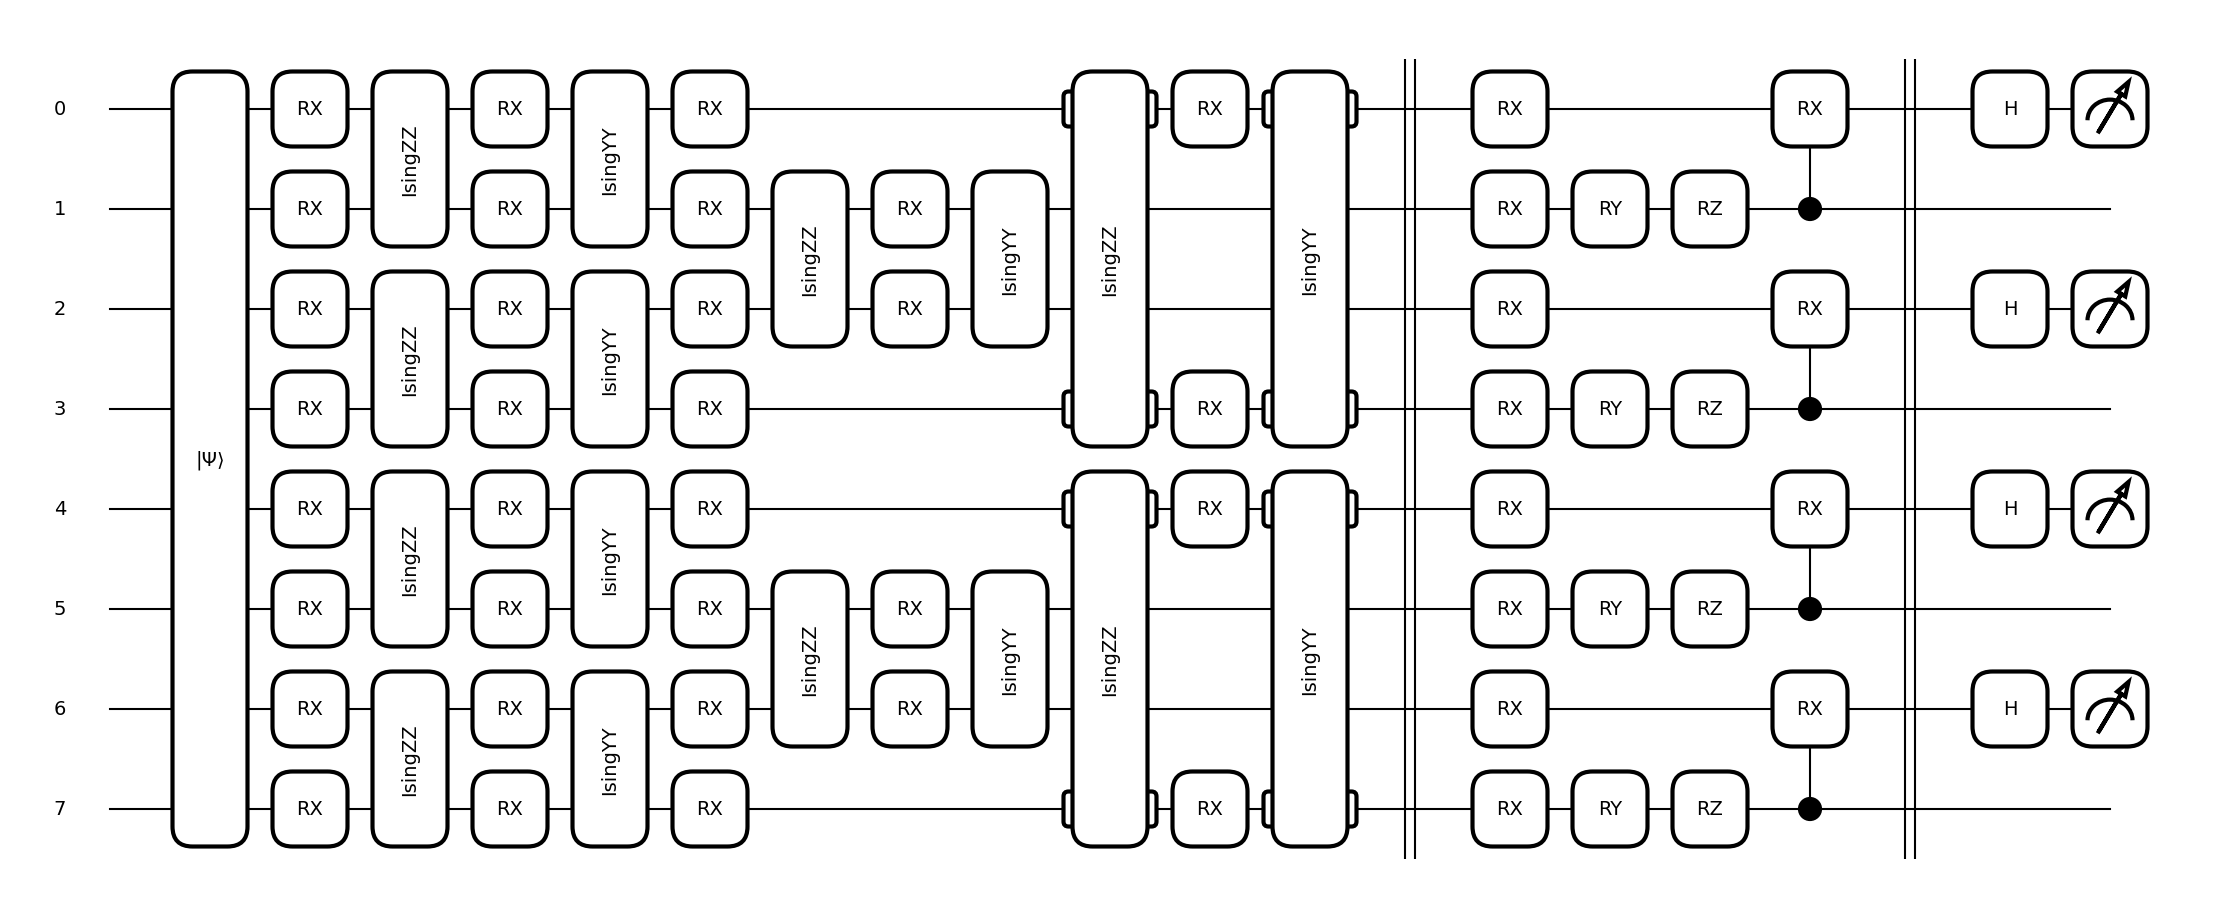

In [112]:
params = np.ones(22)
matrix = np.array(X_train[0])
matrix_reflected = np.fliplr(matrix)
num_qubits = 8

dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def qnode(inputs, params):
    qml.AmplitudeEmbedding(inputs, wires=range(num_qubits), normalize=True)
    qcnn_full(params, [0,1,2,3,4,5,6,7])
    qml.Hadamard(0)
    qml.Hadamard(2)
    qml.Hadamard(4)
    qml.Hadamard(6)
    return qml.probs(wires = [0,2,4,6])

def draw_circuit(matrix, params):
    matrix_np = np.array(matrix)
    params_np = np.array(params)
    @qml.qnode(dev)
    def temp_circuit():
        qml.AmplitudeEmbedding(matrix, wires=range(num_qubits), normalize=True)
        qcnn_full(params_np, [0,1,2,3,4,5,6,7])
        qml.Hadamard(0)
        qml.Hadamard(2)
        qml.Hadamard(4)
        qml.Hadamard(6)
        return qml.probs(wires = [0,2,4,6])

    return qml.draw_mpl(temp_circuit)()

# Draw the circuit
draw_circuit(matrix.reshape(16*16), params)

Now, we can test that this quantum circuit is invariant under reflections over X and Y axis.

 Output with Probabilities for Original Image: [0.05238863 0.03750265 0.05969923 0.08144182 0.07171586 0.06175008
 0.07767212 0.11823911 0.01952063 0.02554456 0.01984457 0.02848712
 0.06881963 0.05677223 0.09277204 0.12782966]
 Output with Probabilities for Image Reflected over Y-axis: [0.05238863 0.03750265 0.05969923 0.08144182 0.07171586 0.06175008
 0.07767212 0.11823911 0.01952063 0.02554456 0.01984457 0.02848712
 0.06881963 0.05677223 0.09277204 0.12782966]
 Output with Probabilities for Image Reflected over X-axis: [0.05238863 0.03750265 0.05969923 0.08144182 0.07171586 0.06175008
 0.07767212 0.11823911 0.01952063 0.02554456 0.01984457 0.02848712
 0.06881963 0.05677223 0.09277204 0.12782966]


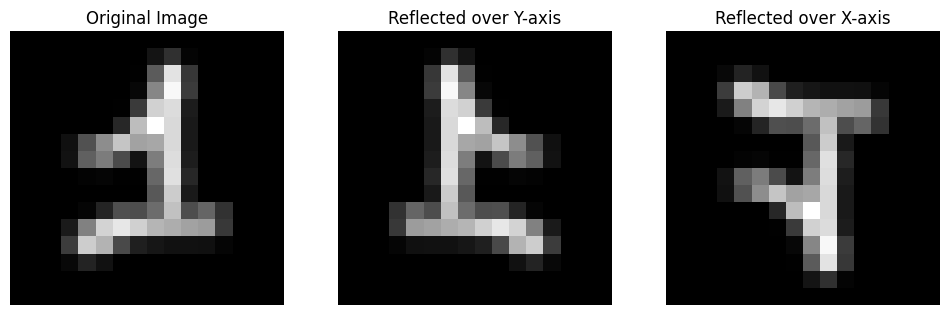

In [113]:
import matplotlib.pyplot as plt

matrix = np.array(X_train[7])

# Image Reflected over Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Image Reflected over X-axis
matrix_reflected_x = np.flipud(matrix)

# array to JAX
matrix_reflected_y_jax = np.array(matrix_reflected_y).reshape(16*16)
matrix_reflected_x_jax = np.array(matrix_reflected_x).reshape(16*16)


result1 = qnode(matrix.reshape(16*16), params)
result2 = qnode(matrix_reflected_y_jax, params)
result3 = qnode(matrix_reflected_x_jax, params)


print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")

# Plot the images in a single row
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  

# Show the original image
axes[0].imshow(matrix, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Show the image reflected over the Y-axis
axes[1].imshow(matrix_reflected_y, cmap='gray')
axes[1].set_title("Reflected over Y-axis")
axes[1].axis('off')

# Show the image reflected over the X-axis
axes[2].imshow(matrix_reflected_x, cmap='gray')
axes[2].set_title("Reflected over X-axis")
axes[2].axis('off')

# Display the images
plt.show()

In [114]:
output = qnode(matrix.reshape(16*16), params)
output.shape

(16,)

In [115]:
weight_shapes = {"params": (93,)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes) 

clayer_1 = torch.nn.Linear(16, 2) 
softmax = torch.nn.Softmax(dim=1) 

layers = [qlayer, clayer_1, softmax]
model = torch.nn.Sequential(*layers)

opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss = torch.nn.L1Loss()

In [116]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

print(model[1].parameters())  

Total trainable parameters: 127
<generator object Module.parameters at 0x7edce8981070>


Output with probabilities for the original image: tensor([[0.4392, 0.5608]], grad_fn=<SoftmaxBackward0>)
Output with probabilities for the image reflected over the Y-axis: tensor([[0.4392, 0.5608]], grad_fn=<SoftmaxBackward0>)
Output with probabilities for the image reflected over the X-axis: tensor([[0.4392, 0.5608]], grad_fn=<SoftmaxBackward0>)


<ipython-input-117-379bb74cea5b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix_tensor = torch.tensor(matrix.reshape(1, 16*16), dtype=torch.float32)  # Convert the original image


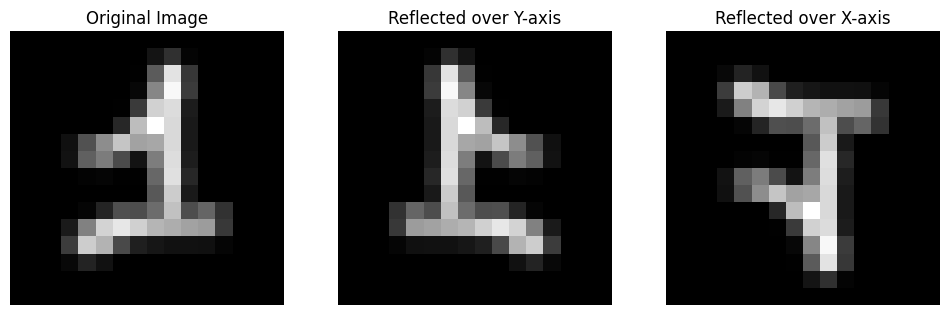

In [117]:
import torch
import matplotlib.pyplot as plt

matrix = X_train[7]

matrix_reflected_y = np.fliplr(matrix)

matrix_reflected_x = np.flipud(matrix)

matrix_tensor = torch.tensor(matrix.reshape(1, 16*16), dtype=torch.float32) 
matrix_reflected_y_tensor = torch.tensor(matrix_reflected_y.reshape(1, 16*16), dtype=torch.float32)  
matrix_reflected_x_tensor = torch.tensor(matrix_reflected_x.reshape(1, 16*16), dtype=torch.float32)  

result1 = model(matrix_tensor)
result2 = model(matrix_reflected_y_tensor)
result3 = model(matrix_reflected_x_tensor)

print(f"Output with probabilities for the original image: {result1}")
print(f"Output with probabilities for the image reflected over the Y-axis: {result2}")
print(f"Output with probabilities for the image reflected over the X-axis: {result3}")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  

# Show the original image
axes[0].imshow(matrix, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Show the image reflected over the Y-axis
axes[1].imshow(matrix_reflected_y, cmap='gray')
axes[1].set_title("Reflected over Y-axis")
axes[1].axis('off')

# Show the image reflected over the X-axis
axes[2].imshow(matrix_reflected_x, cmap='gray')
axes[2].set_title("Reflected over X-axis")
axes[2].axis('off')

# Display the images
plt.show()

### model

In [118]:
import torch
import torch.nn.functional as F

num_classes = 2
samples = 10000
y_train_one_hot = F.one_hot(y_train[:samples].to(torch.int64), num_classes=num_classes)

X = X_train[:samples].reshape(samples, 16*16).float().requires_grad_(True)
y_hot = y_train_one_hot.long()


batch_size = 64
batches = samples // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=batch_size, shuffle=True, drop_last=True
)

epochs = 20

for epoch in range(epochs):
    running_loss = 0
    for xs, ys in data_loader:
        opt.zero_grad()
        y_pred = model(xs)
        loss_evaluated = loss(y_pred, ys)
        loss_evaluated.backward()
        opt.step()
        running_loss += loss_evaluated.item()
    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

Average loss over epoch 1: 0.4919
Average loss over epoch 2: 0.4801
Average loss over epoch 3: 0.4739
Average loss over epoch 4: 0.4703
Average loss over epoch 5: 0.4681
Average loss over epoch 6: 0.4663
Average loss over epoch 7: 0.4652
Average loss over epoch 8: 0.4643
Average loss over epoch 9: 0.4632
Average loss over epoch 10: 0.4622
Average loss over epoch 11: 0.4606
Average loss over epoch 12: 0.4586
Average loss over epoch 13: 0.4561
Average loss over epoch 14: 0.4525
Average loss over epoch 15: 0.4468
Average loss over epoch 16: 0.4389
Average loss over epoch 17: 0.4275
Average loss over epoch 18: 0.4123
Average loss over epoch 19: 0.3932
Average loss over epoch 20: 0.3718


In [119]:
y_pred = model(X)

_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

correct = (y_pred_classes == y_train[:samples].numpy()).sum()
accuracy = correct / len(y_train[:samples])
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 88.97%


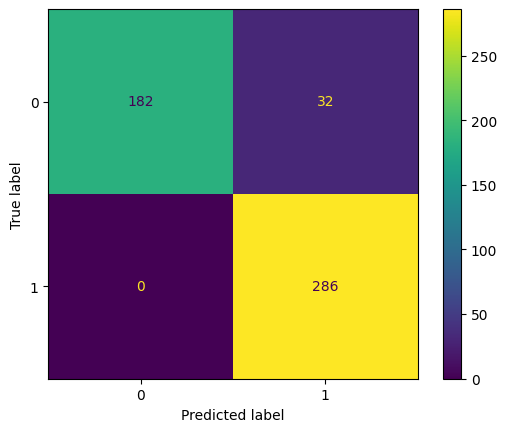

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_samples = 500
X_test = X_test[:test_samples].reshape(test_samples, 16*16).float().requires_grad_(True)

y_pred = model(X_test)
_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

cm = confusion_matrix(y_test[:test_samples], y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()